# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical machine learning techniques, namely:
- unsupervised link prediction based on graph-topology (Adamic Adar, Preferential Attachment, Resource-Allocation-Index, ...)
- supervised link prediction using Logistic Regression, Bagging and Boosting

### 1. Import Packages

In [29]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.modeling' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\modeling.py'>

In [7]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [12]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching train data...
Enriching validation data...
Enriching test data...


In [15]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [24]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 2))
model.load_state_dict(torch.load(path))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data)
node_emb = pd.DataFrame(embedding).rename(columns = {0: "x1", 1: "x2"})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test           = loadData.split_frame(test_tf)

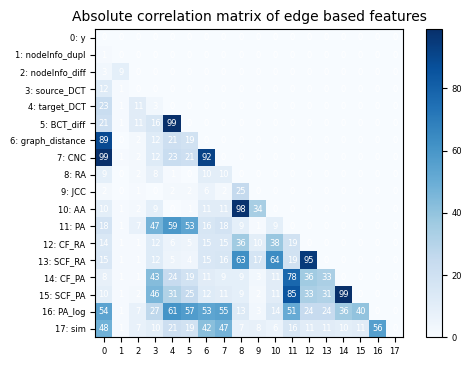

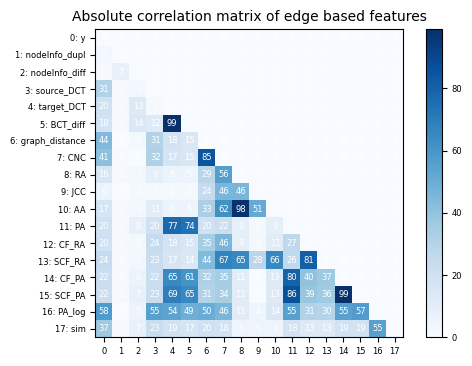

In [20]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

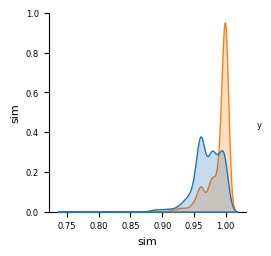

In [21]:
sns.pairplot(val_tf[["sim", "y"]], hue = "y")

### 3. Unsupervised Link Prediction

TODO: try to implement other classical link prediction algos (see lecture 3, Liben-Nowell and Kleinberg Paper in 2003)
- weighted Katz
- Katz clustering
- low-rank inner product
- rooted PageRank
- unseen bigrams
- SimRank
- hitting time

In [67]:
# which cols we want to use for link prediction
cols = ["sim", "CNC", "RA", "JCC", "AA", "PA"] # "graph_distance"

# training data
X_train_lp = X_train[cols]
X_train_lp = X_train_lp.rank(pct = True)
#X_train_lp["graph_distance"] = 1 - X_train_lp["graph_distance"] # graph distance: the lower the better!
y_train_hat = (X_train_lp > 0.9).any(axis = 1).astype(int)
y_train_hat.loc[y_train_hat == 0] = (X_train_lp.loc[y_train_hat == 0].mean(axis = 1) > 0.5).astype(int)

# validation data
X_val_lp = X_val[cols]
X_val_lp = X_val_lp.rank(pct = True)
#X_val_lp["graph_distance"] = 1 - X_val_lp["graph_distance"] # graph distance: the lower the better!
y_val_hat = (X_val_lp > 0.9).any(axis = 1).astype(int)
y_val_hat.loc[y_val_hat == 0] = (X_val_lp.loc[y_val_hat == 0].mean(axis = 1) > 0.5).astype(int)

# test data
X_test_lp = X_test[cols]
X_test_lp = X_test_lp.rank(pct = True)
#X_test_lp["graph_distance"] = 1 - X_test_lp["graph_distance"] # graph distance: the lower the better!
y_test_hat = (X_test_lp.mean(axis = 1) > 0.5).astype(int)

In [68]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4198
           1       0.85      0.85      0.85      4174

    accuracy                           0.85      8372
   macro avg       0.85      0.85      0.85      8372
weighted avg       0.85      0.85      0.85      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1050
           1       0.80      0.73      0.76      1043

    accuracy                           0.77      2093
   macro avg       0.78      0.77      0.77      2093
weighted avg       0.78      0.77      0.77      2093

Roc_auc score
-------------------------------------------------------
0.7743368488334931

Confusion matrix
-------------------------------------------------------
[[860 190]
 [282 761]]


In [69]:
# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)

In [70]:
# look at predicted labels
save_test.value_counts()

Predicted
0            1984
1            1514
dtype: int64

### 4. Supervised Link Prediction

In [117]:
X_train_xg = X_train[[col for col in X_train.columns if col not in ["CNC", "graph_distance"]]]
X_val_xg   =   X_val[[col for col in X_val.columns   if col not in ["CNC", "graph_distance"]]]
X_test_xg  =  X_test[[col for col in X_test.columns  if col not in ["CNC", "graph_distance"]]]

In [124]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBClassifier(n_estimators = 50, max_depth = 3, eta = 0.01, min_child_weight = 400, colsample_bytree = 0.1)
clf.fit(X_train_xg, y_train)

# predict train
y_train_hat = clf.predict(X_train_xg)
# compute R^2 metric
acc_train = accuracy_score(y_train, y_train_hat)

# predict val
y_val_hat = clf.predict(X_val_xg)
# compute R^2 metric
acc_val = accuracy_score(y_val, y_val_hat)

# print performance
print(f"Acc train: {acc_train}")
print(f"Acc val : {acc_val}")

Acc train: 0.78786430960344
Acc val : 0.7620640229335881


In [125]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4198
           1       0.80      0.77      0.78      4174

    accuracy                           0.79      8372
   macro avg       0.79      0.79      0.79      8372
weighted avg       0.79      0.79      0.79      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1050
           1       0.79      0.71      0.75      1043

    accuracy                           0.76      2093
   macro avg       0.76      0.76      0.76      2093
weighted avg       0.76      0.76      0.76      2093

Roc_auc score
-------------------------------------------------------
0.7619015659955258

Confusion matrix
-------------------------------------------------------
[[851 199]
 [299 744]]


In [39]:
# rerun model on whole training data
clf = XGBClassifier(n_estimators = 40, max_depth = 3, eta = 0.05,
                    colsample_bytree = 0.1, colsample_bylevel = 0.5,
                    reg_alpha = 500)
clf.fit(X_trainval, y_trainval)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=40, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=500, ...)

In [173]:
# predict test
y_test_hat = clf.predict(X_test)

In [174]:
# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)

In [175]:
save_test.value_counts()

Predicted
1            1880
0            1618
dtype: int64